### 1. Введение

✍ Добро пожаловать в новый модуль, посвящённый машинному обучению.

В этом модуле мы продолжаем знакомиться с принципами построения моделей на базовом уровне. На этот раз мы поговорим о параметрах модели, а точнее о **гиперпараметрах**.

<img src="data\pic-1.png" alt="drawing" width="1000"/>

**Гиперпараметры** отвечают за сложность взаимосвязи между входными признаками и целевой переменной, поэтому сильно влияют на модель и качество прогнозирования.

Продемонстрируем это на примере задачи **регрессии** с помощью двух графиков работы алгоритма случайного леса, построенного на основе 5, 100 деревьев (n_estimators = [5, 100]):

<img src="data\dst-3-ml-7-1.png" alt="drawing" width="800"/>

Видим, что при 100 деревьях модель находит более сложную закономерность в данных и точность соответственно будет выше, чем при 5.

Каждый алгоритм МО имеет набор гиперпараметров, которые определяют, как именно он строит модель на обучающей выборке. Например, в модуле ML-2 для повышения эффективности модели мы уже рассматривали подбор параметра регуляризации  для алгоритма линейной регрессии Ridge.

Код:

In [1]:
# #Создаем список из 20 возможных значений от 0.001 до 10
# alpha_list = np.linspace(0.01, 10, 20)
# #Создаем пустые списки, в которые будем добавлять результаты 
# train_scores = []
# test_scores = []
# for alpha in alpha_list:
#     #Создаем объект класса линейная регрессия с L2-регуляризацией
#     ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
#     #Обучаем модель предсказывать логарифм целевого признака
#     ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
#     #Делаем предсказание для каждой из выборок
#     #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
#     y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
#     y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
#     #Рассчитываем метрику для двух выборок и добавляем их в списки
#     train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
#     test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))
 
# #Визуализируем изменение R^2 в зависимости от alpha
# fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
# ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
# ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
# ax.set_xlabel('Alpha') #название оси абсцисс
# ax.set_ylabel('MAE') #название оси ординат
# ax.set_xticks(alpha_list) #метки по оси абцисс
# ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
# ax.legend(); #отображение легенды

Результат:

<img src="data\dst-3-ml-7-2.png" alt="drawing" width="800"/>

Наилучшее значение метрики соответствует α=0.01 (кстати, можно попробовать перебрать значения alpha < 0.01).

В данном случае мы просто воспользовались циклом for и перебрали некоторые заданные значения alpha, хотя, по всей видимости, не самые оптимальные. Поэтому подобранные эмпирическим путём значения гиперпараметров с большей вероятностью дадут низкую прогностическую эффективность.

Также рассмотренный метод визуализации зависимости метрики от гиперпараметра позволяет выбрать только один внешний параметр, в данном случае — alpha. А что делать, если у нас не один, а несколько? 

Например, вспомним основные внешние параметры DecisionTreeClassifier:

- **criterion** — критерий информативности. Может быть равен 'gini' — критерий Джини — и 'entropy' — энтропия Шеннона.
- **max_depth** — максимальная глубина дерева. По умолчанию None, глубина дерева не ограничена.
- **max_features** — максимальное число признаков, по которым ищется лучшее разбиение в дереве. По умолчанию None, то есть обучение производится на всех признаках.
- **min_samples_leaf** — минимальное число объектов в листе. По умолчанию — 1.

Мы, конечно, можем сделать кучу вложенных циклов. Однако, поскольку поиск оптимальных значений гиперпараметров является общераспространенной задачей МО, библиотека scikit-learn и другие предлагают методы, позволяющие её решить.

Тщательный подбор гиперпараметров гарантирует, что модель покажет максимально возможную точность на обучающих данных, но это совершенно не означает хороший результат на тестовых или новых данных.

Поиск оптимальных значений гиперпараметров модели является сложной задачей, обязательной почти для всех моделей и наборов данных. Однако важно понимать смысл гиперпараметров перед их подбором.

### ЦЕЛИ МОДУЛЯ

- Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV).
- Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna).
- Научиться их настраивать и обучать модели с их использованием — так, чтобы улучшать итоговую метрику.  
- Провести сравнение и понять преимущества и недостатки каждого из методов.

_________________________________________________________

### 2. Базовая оптимизация

В базовой оптимизации, предоставляемой библиотекой sklearn, есть два основных метода — **grid search** и **random search**. С ними мы сейчас и познакомимся. Оба используются при решении реальных задач, поэтому важно разобраться, как они устроены. 

Наиболее часто используемый метод — это **поиск по сетке (grid search)**, который по сути является попыткой перебрать все возможные комбинации заданных гиперпараметров. Мы указываем список значений для различных гиперпараметров, и, ориентируясь на нашу метрику, оцениваем эффективность модели для каждого их сочетания, чтобы получить оптимальную комбинацию значений.

Допустим, мы хотим подобрать гиперпараметры min_samples_leaf и max_depth для алгоритма DecisionTreeClassifier. Зададим списки их значений:

In [2]:
min_samples_leaf = [3, 5, 8, 9]
max_depth = [4, 5, 6, 7, 8]

Поскольку нам нужно перебрать четыре различных значения для min_samples_leaf и пять — для max_depth, то получается всего 4*5=20 комбинаций. Модель будет обучена 20 раз; столько же раз будет рассчитана метрика.

Сетка выглядит следующим образом:

<img src="data\pic-2.png" alt="drawing" width="1000"/>

### ОПАСНОСТЬ ПЕРЕОБУЧЕНИЯ И УТЕЧКИ ДАННЫХ

Для того, чтобы выбрать оптимальные значения гиперпараметров, мы ориентируемся на выбранную метрику, рассчитанную на тестовой выборке. Мы делали это для подбора гиперпараметра регуляризации alpha, но является ли это надёжным подходом?

*Эту проблему мы уже обсуждали в модуле ML-5 «Валидация и оценка качества моделей».*

Давайте вспомним: мы перебираем множество значений гиперпараметров и выбираем ту комбинацию значений, которая даёт наилучшую точность на тестовых данных. Однако это **совсем не означает, что на новых данных мы получим такой же результат**. 

Поскольку мы использовали тестовый набор для настройки гиперпараметров, мы больше не можем использовать его для оценки качества модели. Теперь в этих целях нам необходим независимый набор данных, то есть набор, который не использовался для построения модели и настройки её гиперпараметров.

Следовательно, надо разбить данные на **три части**: **обучающую** для построения модели, проверочную (**валидационную**) для выбора гиперпараметров модели, а также **тестовую** для оценки качества модели и выбранных гиперпараметров.

<img src="data\dst-3-ml-7-3.png" alt="drawing" width="600"/>

Наличие всех трёх наборов данных критически важно для использования МО. Любой подбор гиперпараметров, сделанный на тестовых данных, «сливает» модели информацию, содержащуюся в них, и может привести к неправильной оценке качества модели. Такая проблема относится к категории утечки данных, которую мы уже тоже затрагивали в модуле по валидации.

Рассмотренный метод разбиения данных на обучающий, проверочный и тестовый наборы является вполне рабочим и относительно широко используемым, но весьма чувствителен к равномерности разбиения данных. 

Для лучшей оценки обобщающей способности вместо одного разбиения данных на обучающий и проверочный наборы мы можем воспользоваться перекрёстной проверкой, то есть кросс-валидацией (cross validation). В таком случае качество модели оценивается для каждой комбинации гиперпараметров по всем разбиениям **кросс-валидации**. 

<img src="data\dst-3-ml-7-4.png" alt="drawing" width="800"/>

**Пояснение к рисунку**. Предположим, что у нас есть n комбинаций гиперпараметров. Берём первую комбинацию и обучаем на них первую модель с помощью кросс-валидации с 10 фолдами (cv=10), затем рассчитываем метрику как среднее по всем разбиениям. Так проделываем для каждой комбинации и выбираем ту, при которой наша метрика наилучшая. В итоге мы обучим n*cv моделей, но выберем один набор гиперпараметров, который и будет использоваться для обучения итоговой модели на всей обучающей выборке.

### GRIDSEARCHCV

Поскольку поиск по сетке с кросс-валидацией является весьма распространённым методом настройки гиперпараметров, библиотека scikit-learn предлагает класс **GridSearchCV**, в котором осуществляется именно такой вариант.

Для этого продолжим решать задачу классификации из модуля ML-3 «Предсказываем категорию дохода человека», где вы изучали алгоритмы МО, а теперь проделаем оптимизацию гиперпараметров для каждого из них.

**Описание данных**
Данные, с которыми мы будем работать, были извлечены из базы данных Бюро переписи населения 1994 года Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной и заключалась в предсказании дохода. Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50 000 $.

Признаки:

- age — возраст
- workclass — сфера занятости
- fnlwgt — общий вес (число людей, которых, по мнению эксперта, представляет эта категория занятости)
- education — уровень образования
- education.num — образовательная ступень (в виде числа)
- marital.status — семейное положение
- occupation — род деятельности
- relationship — родственные отношения
- race — раса
- sex — пол
- capital.gain — ежегодный дополнительный прирост капитала
- capital.loss — ежегодная дополнительная потеря капитала
- hours.per.week — число рабочих часов в неделю
- native.country — страна рождения
- income — категория дохода (целевой признак — более 50К $ или менее 50К $)

In [3]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [4]:
#ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.csv')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Проверяем наличие пропусков

In [5]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [6]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

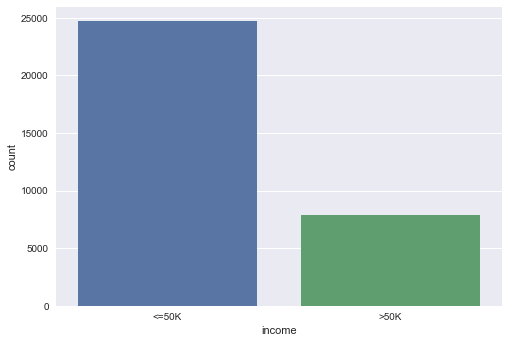

In [7]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [8]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [9]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

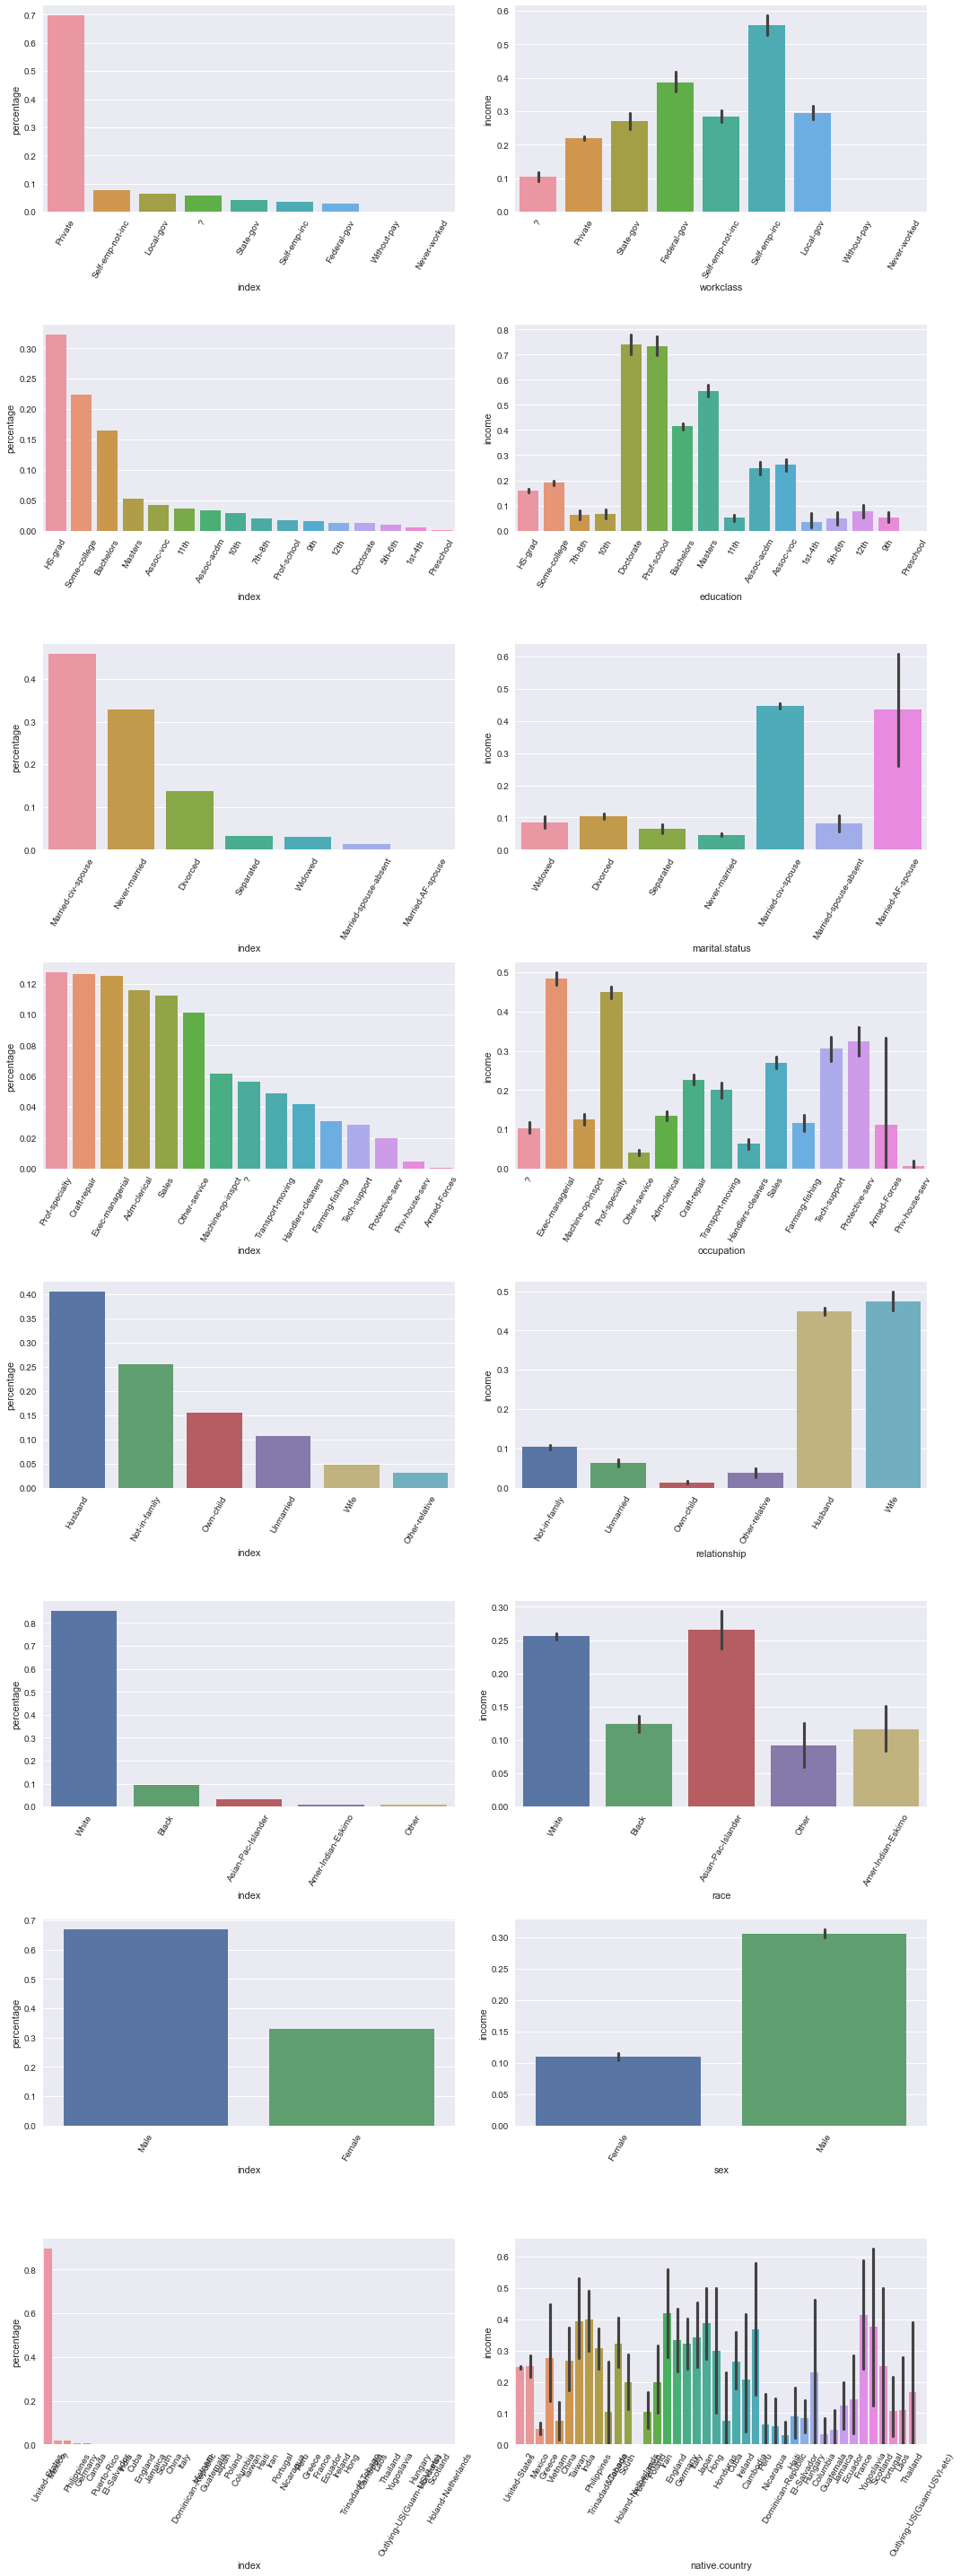

In [10]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [11]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [12]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [13]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [14]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

C:\Users\anton\AppData\Local\Temp\ipykernel_12084\2513722898.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(adult_data.corr(), annot = True);


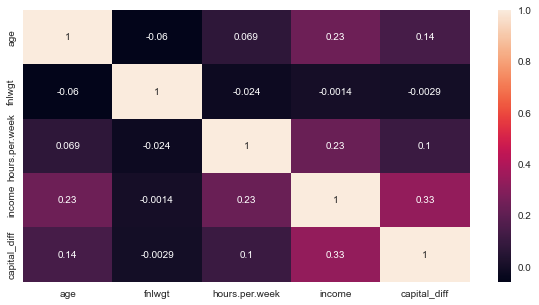

In [15]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(), annot = True);

Кодируем текстовые категориальные признаки

In [16]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [17]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [19]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Приступим к оптимизации гиперпараметров алгоритма логистической регрессии.

Зафиксируем только те метрики, которые были получены без дополнительной настройки, то есть со значениями гиперпараметров, установленных по умолчанию:

In [20]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# accuracy на тестовом наборе: 0.84
# f1_score на тестовом наборе: 0.64

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


### <center> **GridSearchCV**

А теперь попробуем подобрать оптимальные параметры с помощью поиска по сетке. 

Основные параметры GridSearchCV:

- **estimator** — алгоритм, который будем оптимизировать;
- **param_grid** — словарь или список словарей. Словарь с именами гиперпараметров (в формате строки (str), например, 'max_depth') в качестве ключей и списками параметров (например, [5, 8, 10]) в качестве значений. Итого: {'max_depth': [5, 8, 10] }.  
  
Также можно передать список таких словарей:

In [21]:
param_grid = [
              {'max_depth': [5, 8, 10],
               'min_samples_leaf': [7, 8, 9] }, #первый словарь 
              {'n_estimators': [100, 200, 300], 
               'max_depth': [5, 8, 10] } #второй словарь 
             ]

В таком случае каждый словарь в списке перебирается отдельно и последовательно. Это позволяет выполнять поиск по любой последовательности настроек параметров.

- **scoring** — по умолчанию используется score-функция заданного алгоритма:
  
для классификации — sklearn.metrics.accuracy_score;

для регрессии — sklearn.metrics.r2_score;

Возможно выбрать любую другую в зависимости от условий задачи. Различные варианты смотрите здесь.

- **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
- **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
 Чтобы воспользоваться классом GridSearchCV, необходимо:

1. Импортировать библиотеку:

In [22]:
from sklearn.model_selection import GridSearchCV

2. Указать искомые гиперпараметры в виде словаря  param_grid: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров. Мы рассмотрим сетку из:

- 'penalty' — тип регуляризации. Может принимать значения l1,  l2, 'elasticnet' или None (отсутствие регуляризации);
- 'solver' — алгоритм оптимизации, может принимать значения 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', по умолчанию — 'lbfgs'.
Важно помнить, что выбор алгоритма оптимизации зависит от выбранного типа штрафа:

<img src="data\dst-3-ml-7-5.png" alt="drawing" width="800"/>

In [23]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
                  'solver': ['lbfgs', 'saga'] #алгоритм оптимизации
                  }

3. Вызвать класс GridSearchCV и передать модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, и n_jobs = -1, чтобы использовать все доступные ядра для расчётов:

In [24]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=1, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

4. Созданный нами объект grid_search аналогичен классификатору, поэтому мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit(), он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid:

In [25]:
grid_search.fit(X_train_scaled, y_train) 
#Затраченное время: 1min 4s

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=1),
             n_jobs=-1,
             param_grid={'penalty': ['l2', 'none'],
                         'solver': ['lbfgs', 'saga']})

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всём обучающем наборе данных с использованием параметров, которые дают наилучшее значение метрики при кросс-валидации.

 

Наилучшая найденная комбинация гиперпараметров сохраняется в атрибуте **best_params**_:

In [26]:
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
# Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}

Наилучшие значения параметров: {'penalty': 'none', 'solver': 'lbfgs'}


Наилучшая метрика:

In [27]:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.84


Либо можем посмотреть любую другую метрику, воспользовавшись методом predict() и передав предсказанные значения в функцию для расчёта метрики (например, f1_score()): 

In [28]:
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
 
# accuracy на тестовом наборе: 0.84
# f1_score на тестовом наборе: 0.64

f1_score на тестовом наборе: 0.64


Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это неудивительно, и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться!

Попробуем расширить сетку гиперпараметров и проделаем те же шаги:

In [29]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регуляризации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
 
# %time - замеряет время выполнения
%time grid_search_1.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test_scaled, y_test)))
y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))
 
#Затраченное время: 5min 43s (индивидуально, для каждого ПК)
#accuracy на тестовом наборе: 0.84
#f1_score на тестовом наборе: 0.64
#Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l2', 'solver': 'lbfgs'}

CPU times: total: 1.19 s
Wall time: 1min 15s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l2', 'solver': 'lbfgs'}


Метрику опять не удалось улучшить, а времени потратили много, в пять раз больше!

Поиск по сетке не гарантирует, что мы найдём наилучшую комбинацию гиперпараметров. Всё потому, что сетка значений конечна, и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.

Итоговая модель хранится в параметре best_estimator_, ей можно воспользоваться для получения прогнозов на новых данных: 

In [30]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
#Наилучшая модель: LogisticRegression(max_iter=1000, penalty='none', random_state=1)

Наилучшая модель:
LogisticRegression(max_iter=1000, penalty='none', random_state=1)


А наилучшее значение метрики на кросс-валидации (значение метрики, усреднённое по всем разбиениям для данной комбинации гиперпараметров) хранится в атрибуте **best_score_**

In [31]:
print("Наилучшее значение точности при кросс-валидации: {:.2f}".format(grid_search.best_score_))
#Наилучшее значение точности при кросс-валидации: 0.84

Наилучшее значение точности при кросс-валидации: 0.84


**Примечание**. Не путайте **best_score_** со значением метрики модели, которое вычисляется на тестовом наборе с помощью метода **score**. Метод **score** (оценивающий качество результатов, полученных с помощью метода predict()) использует модель, построенную на всём обучающем наборе данных. В атрибуте **best_score_** записывается **средняя метрика на кросс-валидации**.

Результаты кросс-валидации хранятся в параметре **cv_results_**. Отрисуем, как менялась метрика при различных гиперпараметрах:

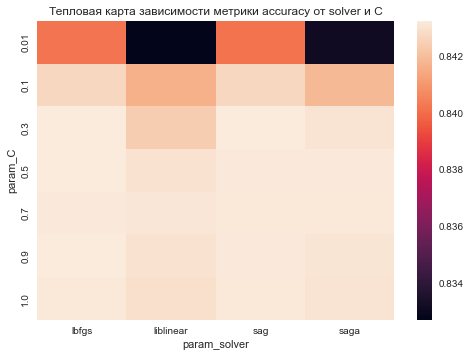

In [32]:
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
               values='mean_test_score', index='param_C',
               columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0.01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0.5 и алгоритмы оптимизации lbfgs и sag работают лучше.

### <center> **RANDOMIZEDSEARCHCV**

Несмотря на то, что поиск по сетке — мощный метод для нахождения оптимального набора гиперпараметров, оценка всех возможных комбинаций требует множество времени и вычислительных ресурсов, а также кросс-валидации для обучения моделей.

Альтернативным подходом подбора различных комбинаций гиперпараметров в библиотеке scikit-learn является **RandomizedSearchCV**. 

**Рандомизированный поиск** работает почти так же, как решётчатый поиск, но он гораздо экономичнее и эффективнее по времени, потому что мы можем задать количество подбираемых комбинаций, а не брать все возможные.

<img src="data\dst-3-ml-7-7.png" alt="drawing" width="900"/>

На этой картинке изображено принципиальное различие двух методов: 

- В GridSearchCV сетка задаётся вручную, перебираются различные значения гиперпараметров с каким-то шагом, в итоге получается что-то похожее на «красивую» сетку слева на картинке. Однако минимум функции (белое пятно) мы так и не обнаруживаем — а ведь он где-то рядом, возможно, просто между подобранными нами комбинациями.
- RandomizedSearchCV выбирает n (количество задаем сами) случайных точек/комбинаций из заданных нами последовательностей. Как следствие, мы можем перебирать не все возможные точки, а только часть из них, тем самым управляя скоростью работы перебора.
  
Основные параметры RandomizedSearchCV аналогичны GridSearchCV, за исключением **n_iter**:

**estimator** — алгоритм, который будем оптимизировать;  
**param_grid** — словарь или список словарей.  

**Примечание**. В ранних версиях sklearn данный параметр был обозначен как param_grid.

Также можно передать список таких словарей:

In [33]:
param_grid = [
              {'max_depth': [5, 8, 10],
               'min_samples_leaf': [7, 8, 9] }, #первый словарь 
              {'n_estimators': [100, 200, 300], 
               'max_depth': [5, 8, 10] } #второй словарь 
             ]

В таком случае каждый словарь в списке перебирается отдельно и последовательно. Это позволяет выполнять поиск по любой последовательности настроек параметров.

- **scoring** — по умолчанию используется score-функция заданного алгоритма:
для классификации — sklearn.metrics.accuracy_score;

для регрессии — sklearn.metrics.r2_score;

Возможно выбрать любую другую в зависимости от условий задачи. Различные варианты смотрите здесь.
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

- **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
- **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
- **n_iter** — количество комбинаций на расчёт. От этого параметра напрямую зависит время оптимизации и качество модели.

✍️ С использованием класса RandomizedSearchCV из библиотеки scikit-learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

Начнём с импорта класса из библиотеки.

In [34]:
from sklearn.model_selection import RandomizedSearchCV
#np.linspace(start(от), stop(до), num=50(количество),dtype-тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
 
 
%time random_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

#Затраченное время: 2 min 20s
#accuracy на тестовом наборе: 0.84
#f1_score на тестовом наборе: 0.64
#Наилучшие значения параметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.89}

CPU times: total: 984 ms
Wall time: 36.1 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.89}


За 10 итераций метрику улучшить не удалось, но обратите внимание на время. Давайте зададим аналогичную сетку, проделаем то же с помощью GridSearchCV и сравним:

In [35]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10,       dtype=float))},
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
  
%time grid_search_2.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test_scaled, y_test)))
y_test_pred = grid_search_2.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

#Затраченное время: 7 min 36s
#accuracy на тестовом наборе: 0.84
#f1_score на тестовом наборе: 0.64
#Наилучшие значения параметров: {'C': 3.34, 'penalty': 'l2', 'solver': 'lbfgs'}

CPU times: total: 1.59 s
Wall time: 1min 45s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 3.34, 'penalty': 'l2', 'solver': 'lbfgs'}


На перебор всей сетки GridSearchCV понадобилось больше времени.

Проделаем аналогичное для DecisionTreeClassifier(). Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [36]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
#Train: 1.00
#Test: 0.62

Train: 1.00
Test: 0.62


Теперь зададим сетку гиперпараметров:

- '**min_samples_leaf**' — минимальное количество объектов в листе;
- '**max_depth**' — максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
- '**criterion**' — критерий информативности.    

И посчитаем RandomizedSearchCV() и GridSearchCV().

In [37]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))
#CPU times: user 1.19 s, sys: 99.9 ms, total: 1.29 s
#Wall time: 18.1 s
#accuracy на тестовом наборе: 0.86
#f1_score на тестовом наборе: 0.65
#Наилучшие значения гиперпараметров: {'min_samples_leaf': 37, 'max_depth': 14, 'criterion': 'entropy'}

CPU times: total: 891 ms
Wall time: 5.3 s
accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.66
Наилучшие значения гиперпараметров: {'min_samples_leaf': 36, 'max_depth': 15, 'criterion': 'gini'}


In [38]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
    )  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))
#CPU times: user 1min 49s, sys: 11.2 s, total: 2min 1s
#Wall time: 37min 5s
#accuracy на тестовом наборе: 0.85
#f1_score на тестовом наборе: 0.65
#Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 39}

CPU times: total: 1min 2s
Wall time: 8min 51s
accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.65
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 39}


Метрику удалось улучшить с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени.

Проделаем аналогичное для RandomForestClassifier. Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [39]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
#Train: 1.00
#Test: 0.66

Train: 1.00
Test: 0.66


Теперь зададим сетку гиперпараметров:

- '**n_estimators**' — количество деревьев в лесу, по умолчанию = 100;
- '**min_samples_leaf**' — минимальное количество объектов в листе;
- '**max_depth**' — максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение.

Посчитаем RandomizedSearchCV() и GridSearchCV().

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# scaler = preprocessing.MinMaxScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)


param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))
#CPU times: user 4.08 s, sys: 113 ms, total: 4.2 s
#Wall time: 1min 55s
#f1_score на обучающем наборе: 0.72
#accuracy на тестовом наборе: 0.86
#f1_score на тестовом наборе: 0.67
#Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 26}

CPU times: total: 2.41 s
Wall time: 24.3 s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': 20}


In [41]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test_scaled, y_test)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))
#CPU times: user 3.85 s, sys: 240 ms, total: 4.09 s
#Wall time: 3min 48s
#f1_score на обучающем наборе: 0.71
#accuracy на тестовом наборе: 0.86
#f1_score на тестовом наборе: 0.67
#Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 110}

CPU times: total: 2.36 s
Wall time: 39.3 s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 110}


На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV в сравнении с GridSearchCV.

**Задание 2.10**

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

n_estimators = от 100 до 200 с шагом 30  
min_samples_leaf = [5, 7]  
max_depth = [10, 15, 20, 25]  
Используйте RandomizedSearchCV с параметрами cv = 5, n_iter = 10.  

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

Впишите в поле не знаю ответ, если хотите увидеть эталонное решение.

In [42]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25],
              }
            
grid_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10 
)  

%time grid_search_forest.fit(X_train_scaled, y_train) 
# y_train_pred = grid_search_forest.predict(X_train_scaled)
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 1min 38s
Wall time: 1min 39s
f1_score на тестовом наборе: 0.67


**Задание 2.11**

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

n_estimators = от 100 до 200 с шагом 30
min_samples_leaf = [5, 7]
max_depth = [10, 15, 20, 25]
Используйте GridSearchCV с параметрами cv = 5.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

Внимание! Оптимизация может занять много времени.

Впишите в поле не знаю ответ, если хотите увидеть эталонное решение.

In [43]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5
    )
%time grid_search.fit(X_train_scaled, y_train) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 5min 19s
Wall time: 5min 24s
f1_score на тестовом наборе: 0.67


### РЕКОМЕНДАЦИИ ПО НАСТРОЙКЕ ГИПЕРПАРАМЕТРОВ АНСАМБЛЕЙ НАД РЕШАЮЩИМИ ДЕРЕВЬЯМИ

**АЛГОРИТМ СЛУЧАЙНОГО ЛЕСА (RANDOMFOREST)**

- **n_estimators** — число итераций (количество деревьев). Частично работает правило «чем больше, тем лучше», но иногда это не имеет особого смысла и сильно увеличивает затраты, поэтому стоит пробовать обучать сотни деревьев [100,200, 300, 400]. Если нет изменений, то оставить минимальное — 100.
- **max_depth** — максимальная глубина дерева. В случайном лесе строятся «сильные» деревья, каждое из которых даёт полноценный прогноз, поэтому глубина деревьем может быть достаточно большой. Стоит следить за переобучением.
- **max_features** — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения;
- **subsample** — доля выборки, которая будет использоваться для обучения каждого алгоритма — дерева.
  
**Примечание**. Так как алгоритм градиентного бустинга мы ещё не проходили, вы можете вернуться в данный раздел, когда изучите модуль ML-8.

**АЛГОРИТМ ГРАДИЕНТНОГО БУСТИНГА (GRADIENTBOOSTING)**

- **n_estimators** — число итераций (количество деревьев) : хотя ошибка на обучении монотонно стремится к нулю, ошибка на контроле, как правило, начинает увеличиваться после определенной итерации. Оптимальное число итераций можно выбирать, например, по отложенной выборке или с помощью кросс-валидации.
- **learning_rate** — темп обучения (0;1]:  
        На практике оказывается, что градиентный бустинг очень быстро строит композицию, ошибка которой на обучении выходит на асимптоту (достигает предела), после чего начинает настраиваться на шум и переобучаться. Параметр **learning_rate** контролирует, насколько сильно каждое дерево будет пытаться исправить ошибки предыдущих деревьев. Более высокая скорость обучения означает, что каждое дерево может внести более сильные корректировки. Как правило, **чем меньше темп обучения, тем лучше качество итоговой композиции**.
- **max_depth** — максимальная глубина дерева. Используется для борьбы с переобучением. Рекомендуется устанавливать не более 5.
- **max_features** — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения.
- **subsample** — доля выборки, которая будет использоваться для обучения каждого алгоритма. Это ещё один способ улучшения качества градиентного бустинга. Таким образом вносится рандомизация в процесс обучения базовых алгоритмов, что снижает уровень шума в обучении, а также повышает эффективность вычислений. 
- 
**Рекомендация**. Берите подвыборки, размер которых вдвое меньше исходной выборки.

<img src="data\dst-3-ml-7-8.png" alt="drawing" width="1000"/>

Главное отличие техник Bagging и Boosting состоит в параллельном и последовательном построении деревьев соответственно.

Основные параметры градиентного бустинга деревьев — это количество деревьев (**n_estimators**) и скорость обучения (**learning_rate**), контролирующие степень вклада каждого дерева в устранение ошибок предыдущих деревьев. Эти два параметра тесно взаимосвязаны, поскольку более низкое значение **learning_rate** означает, что для построения модели аналогичной сложности необходимо большее количество деревьев.

В отличие от случайного леса, в котором более высокое значение **n_estimators** всегда дает лучшее качество, увеличение значения **n_estimators** в градиентном бустинге даёт более сложную модель, что может привести к переобучению. При всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, способные сформировать полноценный прогноз. 

Общепринятая практика для бустинга — подгонять **n_estimators** в зависимости от бюджета времени и памяти, а затем подбирать различные значения **learning_rate**.

Подробнее о градиентном бустинге можно почитать по ссылке.   
http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html

________________________________________________________

### 3. Продвинутая оптимизация

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации — на приведённых крохотных сетках по нескольким параметрам это занимает минуты, но в реальных масштабах это занимает часы и сутки. Поэтому в идеале мы хотим оптимизировать гиперпараметры самым эффективным образом. 

Один из способов  — это **байесовская оптимизация**. Она отличается от случайного поиска или поиска по сетке тем, что учитывает предыдущие результаты, а не выбирает комбинации из вариантов, не имеющих информации о прошлых оценках. Во многих случаях это позволяет найти лучшие значения гиперпараметров модели за меньшее количество времени. Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей МО.

Существует несколько разных алгоритмов для этого типа оптимизации, но особенно используемым является **Tree-Structured Parzen Estimators (TPE)**.

### TREE-STRUCTURED PARZEN ESTIMATORS (TPE)

1. На каждой итерации алгоритм TPE учитывает информацию о прошлых опробованных комбинациях гиперпараметров и только потом принимает решение, какой набор следует попробовать дальше. 

Чтобы приступить к использованию TPE, необходимо выполнить несколько итераций с помощью случайного поиска. 

2. На следующем шаге происходит разделение собранных наборов на две группы:

- в первую группу входят наборы, дающие наилучшие результаты после оценки;
- во вторую — все остальные.
На изображении ниже: первая группа — **красные точки** находятся в области минимума целевой функции; вторая группа — **синие точки**, все остальные.

<img src="data\dst-3-ml-7-9.png" alt="drawing" width="800"/>

Основная цель алгоритма — найти набор гиперпараметров, который с большей вероятностью будет в первой группе и с меньшей вероятностью во второй группе. Таким образом, для принятия следующего решения используется целое распределение наилучших комбинаций — **красные точки** на графике.

3. Далее TPE моделирует вероятности правдоподобия для каждой из групп, используя формулу Байеса:

$$p(y|x) = \frac{p(x|y) \times p(y)}{p(x)}$$

где  x — гиперпараметры,  y — соответствующая оценка качества модели.

Подробнее про теорему Байеса можно прочитать по ссылке.
https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%B0

4. Затем, используя вероятность правдоподобия из первой группы, отбирается набор комбинаций, которые с большей вероятностью попадут в первую группу и с меньшей вероятностью — во вторую. 

$$p(x|y) = \begin{cases} l(x)& \text{ if } y<y* \\ g(x) & \text{ if } y\geq y* \end{cases}$$

где  $p (x | y)$ — это вероятность гиперпараметров с учётом оценки целевой функции, $l(x)$ — вероятность быть в первой группе, $g(x)$ — вероятность быть во второй группе

Определяем ожидаемое улучшение для каждой комбинации:

$$\mathbb {E}\left [I(x) \right ] = \frac{l(x)}{g(x)}$$

где $\mathbb {E}$ — это знак математического ожидания.  

5. Шаги 2-4  будет выполняться до тех пор, пока не будет достигнуто максимальное количество итераций. 

В итоге мы найдём наилучшую комбинацию гиперпараметров.

Более подробное описание алгоритма с математическими выкладками вы можете найти здесь.  
https://ml-handbook.ru/chapters/hyperparameters_tuning/intro#tree-structured-parzen-estimator-tpe

### <center>  **HYPEROPT**

**Hyperopt** — это библиотека Python с открытым исходным кодом на основе байесовской оптимизации, в которой реализован алгоритм **Tree-Structured Parzen Estimators (TPE)**.

Три шага для использования Hyperopt:

1. Задание пространства поиска гиперпараметров. 

Объявляем список гиперпараметров, тип распределения и его границы.

Основные типы:

hp.choice(label, options) #равновероятный выбор из множества  

hp.randint(label, upper) #случайное целое число; random seed, например   

hp.uniform(label, low, high) #равномерное непрерывное распределение  

hp.normal(label, mu, sigma) #нормальное непрерывное распределение  

hp.lognormal(mu, sigma) #логнормальное непрерывное распределение  

Используйте для:

- категориальных — hp.choice;
- целочисленных —  hp.randit, hp.quniform;
- непрерывных — аналогично целочисленным и hp.normal, hp.uniform, hp.lognormal, hp.loguniform.

2. Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики. Можем минимизировать/максимизировать значение метрики.

3. Задание алгоритма поиска:

Random Search.
Tree of Parzen Estimators (TPE).

Полезные ссылки: 

Hyperopt: A Python Library for Optimizing the Hyperparameters of Machine Learning Algorithms https://lms.skillfactory.ru/assets/courseware/v1/32710b2c3069452833036ea0e4da10fe/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/bergstra_hyperopt.pdf  
Hyperopt на GitHub  https://github.com/hyperopt/hyperopt/  
Байесовский ниндзя (Хабр)  https://habr.com/ru/post/494242/

✍️ Посмотрим, как выполнить эти шаги с помощью Hyperopt.

**Примечание.** Если на этапе подбора гиперпараметров у вас возникла ошибка, не переживайте, это из-за разницы версий библиотеки.

Для версии hyperopt==0.2.5 все отработает верно.  
Для версии hyperopt==0.2.7 будет ошибка из-за изменений в определении параметра rstate, теперь вместо rstate=np.random.  RandomState(random_state), необходимо использовать другой генератор случайных чисел: rstate=np.random.default_rng(random_state).  

**версия библиотеки никак не влияет на подбор параметров, но хорошим тоном считается своевременное обновление модулей, хотя в действительности это часто влечет возникновение ряда других ошибок из-за нарушений зависимостей, поэтому осуществляется по необходимости.*

In [44]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

# Версия Hyperopt : 0.2

Версия Hyperopt : 0.2.7


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [46]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс Hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации. Она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [47]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [61]:
# начинаем подбор гиперпараметров
# %%time
random_state = 42
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

#100%|██████████| 20/20 [01:10<00:00,  3.50s/it, best loss: -0.7986892215038526]
#Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
#CPU times: user 1min 10s, sys: 183 ms, total: 1min 10s
#Wall time: 1min 10s

100%|██████████| 20/20 [01:29<00:00,  4.49s/trial, best loss: -0.7639828998931244]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 3.0, 'n_estimators': 130.0}


In [62]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

#f1_score на обучающем наборе: 0.80
#accuracy на тестовом наборе: 0.86
#f1_score на тестовом наборе: 0.68

f1_score на обучающем наборе: 0.76
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты!

In [64]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдущих итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

#100%|██████████| 3/3 [00:08<00:00,  2.89s/it, best loss: -0.7986892215038526]
#Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}

100%|██████████| 23/23 [00:14<00:00,  4.98s/trial, best loss: -0.7667794196190137]
Наилучшие значения гиперпараметров {'max_depth': 32.0, 'min_samples_leaf': 3.0, 'n_estimators': 220.0}


Видим, что Hyperopt смог улучшить нашу метрику, причём за меньшее время.

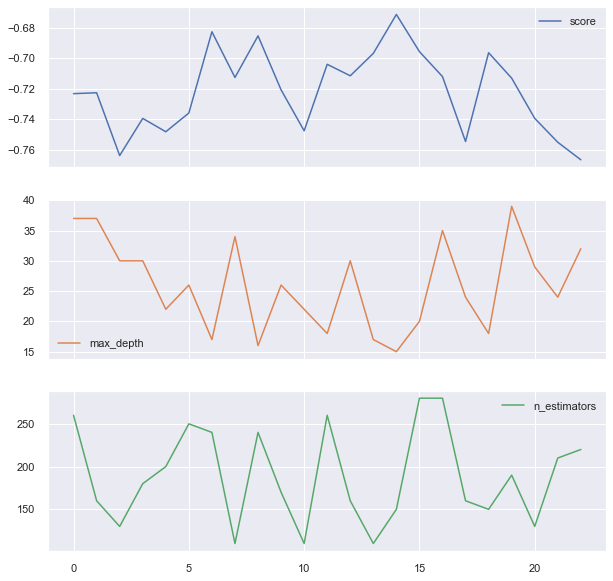

In [65]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

#array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2883875490>,
       #<matplotlib.axes._subplots.AxesSubplot object at 0x7f28838d9d90>,
       #<matplotlib.axes._subplots.AxesSubplot object at 0x7f288412bf90>],
      #dtype=object)

По графикам видно, что лучшая точность достигается именно в best_params. Однако заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как Hyperopt может только минимизировать.

**Задание 3.5**

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

n_estimators = от 100 до 300 включительно с шагом 10  
min_samples_leaf = от 3 до 7 с шагом 1  
max_depth = от 15 до 40 с шагом 1  
Используйте Hyperopt с параметрами max_evals = 20.  

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).



In [66]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [67]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [68]:
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
          rstate=np.random.default_rng(random_state)
         )
#print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:29<00:00,  4.48s/trial, best loss: -0.7639828998931244]


In [69]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
# y_train_pred = model.predict(X_train_scaled)
# print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.68


### <center>  **OPTUNA**

**Optuna** — это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию алгоритм удаляет комбинации, в которых модель даёт качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и другими.

Три шага для использования Optuna: 

1. Задание пространства поиска гиперпараметров.

Основные функции:

- suggest_categorical(name, choices) — для категориальных гиперпараметров;  
- suggest_int(name,low,high,step=1,log=False) — для целочисленных гиперпараметров;
- suggest_float(name,low,high,step=None,log=False) — для непрерывных гиперпараметров;
- suggest_uniform(name,low,high) — для целочисленных и непрерывных гиперпараметров.  
С помощью необязательных аргументов step и log можно дискретизировать или взять логарифм целочисленных и непрерывных параметров.

2. Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики, можем минимизировать/максимизировать значение метрики. На данном этапе будет обучена модель только на одной комбинации гиперпараметров.

3. Создание объекта исследования create study. 

По умолчанию используется алгоритм поиска TPE (есть и другие варианты) и вызов метода optimize(), в который передаётся целевая функция, созданная на первом шаге. Выполняется заданное n_trials раз, подставляются различные комбинации гиперпараметров.

Код и интерактивные графики смотрите в ноутбуке, который вы скачали в юните 2. 
https://lms.skillfactory.ru/assets/courseware/v1/46b076b9d771a4f47290a45945e7ef2e/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ML-7.Optimization_of_hyperparameters.ipynb

Официальный сайт Optuna https://optuna.org/

**Задание 3.10**

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

n_estimators = от 100 до 300 включительно с шагом 10
min_samples_leaf = от 3 до 7 с шагом 1
max_depth = от 15 до 40 с шагом 1
Используйте Optuna с параметрами n_trails = 20.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

Впишите в поле не знаю ответ, если хотите увидеть эталонное решение.

In [ ]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import optuna
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.0.3


In [90]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))

  return score


In [91]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

print("f1_score на тестовом наборе: {:.2f}".format(study.best_value))

[I 2022-12-24 21:25:47,091] A new study created in memory with name: RandomForestClassifier
[I 2022-12-24 21:25:52,907] Trial 0 finished with value: 0.6768005790807093 and parameters: {'n_estimators': 170, 'max_depth': 39, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6768005790807093.
[I 2022-12-24 21:25:58,947] Trial 1 finished with value: 0.6748911465892597 and parameters: {'n_estimators': 280, 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6768005790807093.
[I 2022-12-24 21:26:02,551] Trial 2 finished with value: 0.6715435259692758 and parameters: {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6768005790807093.
[I 2022-12-24 21:26:05,949] Trial 3 finished with value: 0.6703216374269005 and parameters: {'n_estimators': 170, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6768005790807093.
[I 2022-12-24 21:26:12,016] Trial 4 finished with value: 0.6705925653294075 and parameters: {'n_

f1_score на тестовом наборе: 0.68
CPU times: total: 1min 14s
Wall time: 1min 17s


Эталонный ответ:

In [89]:
def optuna_gb(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                     min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  return score
# зафксируем random_state
random_state =42
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=20)
 
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2022-12-24 21:24:05,713] A new study created in memory with name: RandomForestClassifier
[I 2022-12-24 21:24:12,277] Trial 0 finished with value: 0.7243555074815214 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7243555074815214.
[I 2022-12-24 21:24:18,096] Trial 1 finished with value: 0.7086268410941359 and parameters: {'n_estimators': 270, 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7243555074815214.
[I 2022-12-24 21:24:24,971] Trial 2 finished with value: 0.7193475305845037 and parameters: {'n_estimators': 300, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7243555074815214.
[I 2022-12-24 21:24:29,743] Trial 3 finished with value: 0.7124010554089709 and parameters: {'n_estimators': 210, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7243555074815214.
[I 2022-12-24 21:24:36,740] Trial 4 finished with value: 0.7395440674923713 and parameters: {'n_

f1_score на тестовом наборе: 0.68


### ПЛЮСЫ И МИНУСЫ РАССМОТРЕННЫХ ФРЕЙМВОРКОВ И БИБЛИОТЕК

<img src="data\pic-3.png" alt="drawing" width="1000"/>
<img src="data\pic-4.png" alt="drawing" width="1000"/>

__________________________________________________

### ✍️ 4. Практика

Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).  
https://www.kaggle.com/c/bioresponse  
Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).


Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

- Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

<img src="data\dst-3-ml-7-10.png" alt="drawing" width="600"/>

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: **логистическую регрессию и случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать **все четыре метода** (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### Подбор параметров для модели **логистической регресии**

In [4]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


c:\Users\Work\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### GridSearchCV (для логистической регресии)

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': list(np.linspace(0.01, 10, 10, dtype=float))}
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
#print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 6.16 s
Wall time: 3min 33s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 1.12, 'penalty': 'l2', 'solver': 'saga'}


c:\Users\Work\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### RandomizedSearchCV (для логистической регресии)

In [6]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
#print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 1.73 s
Wall time: 57.7 s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.12}


c:\Users\Work\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Hyperopt (для логистической регресии)

In [11]:
import warnings
warnings.filterwarnings("ignore")

#Напишем функции для убыстрения расчета модельных данных
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=42): #функция модели линейная регрессия
    # используем эту комбинацию для построения модели
    model_lr = linear_model.LogisticRegression(**params, random_state=random_state)
    # обучаем модель
    model_lr.fit(X, y)
    score = metrics.f1_score(y,model_lr.predict(X))
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model_lr, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

# начинаем подбор гиперпараметров для модели логистической регрессии
space_lr = hp.choice(
    'logreg_params',
    [
        {
            'penalty': hp.choice('penalty_1', ['l2', 'none']),
            'solver': hp.choice('solver_1', ['lbfgs', 'newton-cg', 'sag']),
            'C': hp.choice('С_1', list(np.linspace(0.01, 1, 10, dtype=float)))
        },
        {
            'penalty': hp.choice('penalty_2', ['l1', 'l2']),
            'solver': hp.choice('solver_2', ['liblinear', 'saga']),
            'C': hp.choice('С_2', list(np.linspace(0.01, 1, 10, dtype=float)))
        }
    ]
)
random_state = 42
trials = Trials() # используется для логирования результатов
best=fmin(hyperopt_lr, # наша функция
          space=space_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=best['penalty_1'],
    solver=best['solver_1'],
    C=best['C_1']
    # penalty=best['penalty'],
    # solver=best['solver'],
    # C=best['C']
)
model.fit(X_train, y_train)
# y_train_pred = model.predict(X_train_scaled)
# print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 50/50 [18:35<00:00, 22.32s/trial, best loss: -0.7831177392651217]  
Наилучшие значения гиперпараметров {'logreg_params': 0, 'penalty_1': 0, 'solver_1': 0, 'С_1': 1}


KeyError: 'C_1'

In [37]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }
params = {'penalty': ['l2', 'none'] ,
            'solver': ['lbfgs', 'sag'],
            'C': list(np.linspace(0.01, 1, 10, dtype=float))},

# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': int(params['penalty']), 
              'solver': int(params['solver']), 
             'C': int(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


# начинаем подбор гиперпараметров
#%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
# y_train_pred = model.predict(X_train_scaled)
# print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: 'penalty'



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


KeyError: 'penalty'

### Optuna (для логистической регресии)

In [ ]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = linear_model.LogisticRegression(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression, direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)


# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))


# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

_________________________________________________

### Подбор параметров для модели **случайный лес**

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

### GridSearchCV (для случайного леса)

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': list(np.linspace(0.01, 10, 10, dtype=float))}
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        #max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
#print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 2.59 s
Wall time: 7min 41s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [13]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
#print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 5.92 s
Wall time: 10min 17s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.23}


### Hyperopt (для случайного леса)

In [14]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


In [15]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [17]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [20]:
# начинаем подбор гиперпараметров
#%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [03:03<00:00,  3.67s/trial, best loss: -0.9920343137254902]
Наилучшие значения гиперпараметров {'max_depth': 23.0, 'min_samples_leaf': 2.0, 'n_estimators': 172.0}


In [21]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
# y_train_pred = model.predict(X_train_scaled)
# print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


## Optuna (для случайного леса)

In [24]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.0.3


In [27]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [28]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2022-12-28 07:06:19,861] A new study created in memory with name: RandomForestClassifier
[I 2022-12-28 07:06:22,886] Trial 0 finished with value: 0.8969957081545065 and parameters: {'n_estimators': 122, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8969957081545065.
[I 2022-12-28 07:06:27,618] Trial 1 finished with value: 0.9351681957186544 and parameters: {'n_estimators': 163, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9351681957186544.
[I 2022-12-28 07:06:30,239] Trial 2 finished with value: 0.9358190709046454 and parameters: {'n_estimators': 124, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9358190709046454.
[I 2022-12-28 07:06:34,028] Trial 3 finished with value: 0.9469512195121951 and parameters: {'n_estimators': 172, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9469512195121951.
[I 2022-12-28 07:06:37,401] Trial 4 finished with value: 0.9155446756425949 and parameters: {'n

In [29]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 195, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [30]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


_________________________________________________________

### 5. Итоги

В этом модуле мы научились реализовывать оптимизацию гиперпараметров как с помощью базовых методов (GridSeachCV, RandomizedSearchCV из библиотеки sklearn), так и с помощью продвинутых методов байесовской оптимизации (фреймворки Hyperopt, Optuna).

Оптимизация гиперпараметров на основе байесовского алгоритма может быть **более эффективной**, чем полный перебор или случайный поиск, так как учитывает прошлые результаты, что позволяет находить лучший набор гиперпараметров модели за меньшее количество итераций поиска и времени — хотя и не во всех случаях.

Важно также помнить, что лучшие гиперпараметры модели на обучающей выборке не означают, что они будут лучшими и на тестовой выборке! Есть шанс переобучения, поэтому лучше **не игнорировать кросс-валидацию** — переобучение по-прежнему остается одной из главных проблем машинного обучения.

**Байесовская оптимизация** — это мощный метод, который можно использовать для настройки любой модели МО, если есть возможность определить целевую функцию, которую необходимо минимизировать/максимизировать, и пространство поиска, в котором нужно искать. 

Для многих задач в машинном обучении нет единственно верного решения. Так же обстоит дело и с настройками гиперпараметров. Однако библиотеки, которые мы рассмотрели в модуле, значительно упрощают утомительный, но столь необходимый процесс оптимизации.

Важно также понимать, что какими бы мощными библиотеками и инструментами мы ни владели, прежде всего важно знание алгоритмов МО и понимание влияния внешних параметров на них. Байесовская оптимизация, конечно, учитывает прошлые комбинации, но она никак не учитывает взаимодействие гиперпараметров между собой внутри комбинации. 

⭐️ На собеседованиях вас могут спросить, что такое оптимизация гиперпараметров  и какие способы решения этой задачи вы знаете, и в чём их отличие: в этом модуле мы рассмотрели четыре основных и часто используемых метода, а также сравнили их работу на разных алгоритмах. 

Вас также могут спросить о конкретном гиперпараметре и его влиянии, поэтому необходимо разбираться в математическом аппарате алгоритмов. Эту тему вы изучите далее!